In [1]:
overall_t1 <- proc.time()

# Parallelization of R code using the future package

In R, numerous packages can be used to parallelize code (parallel, snow, foreach, etc.), but each of  these packages use unique syntaxes and none of them work for all cases of parallelization. Instead, the [future package](https://github.com/HenrikBengtsson/future) solves this problem by creating unified sty

processors and multiple nodes for iterative processes. Briefly (see [future package](https://github.com/HenrikBengtsson/future) for details), the future package works in three steps:

1. Choose how you want to parallelize your code
    \* set the type of parallelization with the plan() object.  
2. Choose which part of the code you would like to run in parallel
    \* place the part of the code that will be iterated within the future({}) object. 
3. Evaluate the code. 
    \* run the iterations using the value() object. 

Here are a few examples to demonstrate some common iterative problems in R. The last two examples use packages that extend the future framework to work with tidyverse code and running scripts on multiple nodes. 
\* For-loop with a very slow function
\* calculate linear models within a tidyverse/purrr framework using the furrr package. 
\* For-loop running multiple Bayesian models across multiple nodes using the future.batchtools package. 

make sure you are on a node with 8 cores via an interactive node or logged into Jupyter before running the code. 

## Packages 

All the packages needed to run this quickbyte. I placed all of my packages within the ~/R/Jupyter directory, but choose your a directory for your code. If you have issues loading the packages due to conflicts in the dependencies, try to install these packages in the terminal. 

In [23]:
# double check you have multiple cores available


path_to_packages <- "~/R/Jupyter"

install.packages("future", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("future.batchtools", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("repurrrsive", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("future.batchtools", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("Hmsc", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8) 
install.packages("purrr", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("dplyr", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("furrr", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("tidyr", lib = path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)
install.packages("snow", lib =  path_to_packages, repos='http://cran.us.r-project.org', Ncpus = 8)


In [24]:
library(future, lib.loc = path_to_packages) # needed for all examples
library(purrr, lib.loc = path_to_packages) # needed for tidyvese example
library(dplyr, lib.loc = path_to_packages) # needed for tidyverse examaple
library(furrr, lib.loc = path_to_packages) # needed for tidyverse examaple
library(repurrrsive, lib.loc = path_to_packages) # loads in data for tidyverse examaple
library(future.batchtools, lib.loc = path_to_packages) # needed for bayesian example
library(coda, lib.loc = path_to_packages) # needed to load Hmsc for bayesian example
library(Hmsc, lib.loc = path_to_packages) # needed for bayesian example
library(tidyr, lib.loc = path_to_packages) # needed for tidyverse examaple
library(snow, lib.loc = path_to_packages) # needed to load Hmsc for bayesian example

# double-check you have access to mulitple cores 
availableCores()

# check that you can run multicore (will fail for R-studio and windows!)
supportsMulticore()

system 
     8

[1] TRUE

## 1. For-loop Example

This examaple shows how the future package can be helpful for running a for-loop that iterates over a very slow function.

### Setup and loop in serial

In [25]:
# custom function that waits a half a second and then prints current step value
slow_function <- function(step){
  
  # wait half a second
  Sys.sleep(.5)
  
  # print out which step you are on
  paste0("Step ", step, " completed")
}


#### running loop in serial ####
# timestampe before loop 
t1 <- proc.time()
# pre-allocate output 
output <- rep(NA, 50)

# for-loop
for (i in 1:50){
  output[i] <- slow_function(i)

}

# print the output at every step
print(output)

# timestampe after loop 
t2 <- proc.time()


print("Elapsed time for for-loop")
# length of time
t2 - t1


 [1] "Step 1 completed"  "Step 2 completed"  "Step 3 completed" 
 [4] "Step 4 completed"  "Step 5 completed"  "Step 6 completed" 
 [7] "Step 7 completed"  "Step 8 completed"  "Step 9 completed" 
[10] "Step 10 completed" "Step 11 completed" "Step 12 completed"
[13] "Step 13 completed" "Step 14 completed" "Step 15 completed"
[16] "Step 16 completed" "Step 17 completed" "Step 18 completed"
[19] "Step 19 completed" "Step 20 completed" "Step 21 completed"
[22] "Step 22 completed" "Step 23 completed" "Step 24 completed"
[25] "Step 25 completed" "Step 26 completed" "Step 27 completed"
[28] "Step 28 completed" "Step 29 completed" "Step 30 completed"
[31] "Step 31 completed" "Step 32 completed" "Step 33 completed"
[34] "Step 34 completed" "Step 35 completed" "Step 36 completed"
[37] "Step 37 completed" "Step 38 completed" "Step 39 completed"
[40] "Step 40 completed" "Step 41 completed" "Step 42 completed"
[43] "Step 43 completed" "Step 44 completed" "Step 45 completed"
[46] "Step 46 completed" 

   user  system elapsed 
  0.021   0.003  25.055 

###  Rerunning for-loop in parallel
Now we will re-write the for-loop so it is compatible with future. We will choose to run it across every core in the node we are using. 

WARNING: if you plan to run this example locally on R-studio, you will need to change it to plan(multisession). 

#### 1. Choose how you want to parallelize your code

In [26]:
#### rerunning loop in parallel using all available cores ####
# going to send iterations to each cores
# to run it only on specified number of cores, add the argument, workers. 
plan(multicore)

iterations <- 50
# rewrite loop so it works with future:
# future requires the iterative step to be saved as its own list, 
# thus we will create a list object with 50 slots for each step. 
output <- vector(mode = "list", length = iterations)



#### 2. Choose which part of the code you would like to run in parallel
we are rewriting the for-loop here. 

we place the section we want to iterate within curly-brackets of the future() object. The the output is written to each list of the y object. 

WARNING: Setting up the lists prior to evaluation can be slow. It is possible for an efficient for-loop with a minimal number of iterations to be faster in serial than running in parallel. 

In [28]:

t1 <- proc.time()
for (i in 1:iterations){

  command_set[[i]] <- future(
    # code for each iteration within the curly brackets
    {slow_function(i)}
  ) 
}


t2 <- proc.time()


print("Elapsed time for setting up iterations")
# length of time
t2 - t1

output

[1] "Elapsed time for setting up iterations"


   user  system elapsed 
  1.517   4.982  13.824 

[[1]]
MulticoreFuture:
Label: ‘<none>’
Expression:
{
    slow_function(i)
}
Lazy evaluation: FALSE
Asynchronous evaluation: TRUE
Local evaluation: TRUE
Environment: R_GlobalEnv
Capture standard output: TRUE
Capture condition classes: ‘condition’
Globals: <none>
Packages: <none>
L'Ecuyer-CMRG RNG seed: <none> (seed = FALSE)
Resolved: TRUE
Value: 136 bytes of class ‘character’
Early signaling: FALSE
Owner process: a8aca22b-4c11-680c-759b-a4cf9b51a3d5
Class: ‘MulticoreFuture’, ‘MultiprocessFuture’, ‘Future’, ‘environment’

[[2]]
MulticoreFuture:
Label: ‘<none>’
Expression:
{
    slow_function(i)
}
Lazy evaluation: FALSE
Asynchronous evaluation: TRUE
Local evaluation: TRUE
Environment: R_GlobalEnv
Capture standard output: TRUE
Capture condition classes: ‘condition’
Globals: <none>
Packages: <none>
L'Ecuyer-CMRG RNG seed: <none> (seed = FALSE)
Resolved: TRUE
Value: 136 bytes of class ‘character’
Early signaling: FALSE
Owner process: a8aca22b-4c11-680c-759b-a4cf9b51a3d5
Class: ‘MulticoreFutu

####  3. Evaluate the code
The value() object will take the list and run the code in parallel. 

In [7]:
# evaluate, distribute each iteration here 
comp_results <- value(command_set)

# ouput is here but separates lists. 
print("list output")
head(comp_results) # using head to limit output


# we can combine them into a vector using unlist()
print("array output")
head(unlist(comp_results)) # using head to limit output

[1] "list output"


[[1]]
[1] "Step 1 completed"

[[2]]
[1] "Step 2 completed"

[[3]]
[1] "Step 3 completed"

[[4]]
[1] "Step 4 completed"

[[5]]
[1] "Step 5 completed"

[[6]]
[1] "Step 6 completed"

[1] "array output"


[1] "Step 1 completed" "Step 2 completed" "Step 3 completed" "Step 4 completed"
[5] "Step 5 completed" "Step 6 completed"

all in one block:

In [8]:
# plan
plan(multicore)

output <- vector(mode = "list", length = 50)
t1 <- proc.time()

for (i in 1:50){
  output[[i]] <- future(
    # but code for each iteration with curly brackets
    {slow_function(i)}
  ) 
}

# evaluate
output <- value(output)

# ouput is here
head(unlist(output))


# timestampe after loop 
t2 <- proc.time()


print("Elapsed time for future example:")
# length of time
t2 - t1

[1] "Step 1 completed" "Step 2 completed" "Step 3 completed" "Step 4 completed"
[5] "Step 5 completed" "Step 6 completed"

[1] "Elapsed time for future example:"


   user  system elapsed 
  1.575   3.392  11.901 

## 1. Tidyverse example using the furrr package

To change tidyverse code, all that is needed is to set up the parallelization (plan object) and then replace the map object with future_map. The evaluation step is completed with the future_map object. 

### Set-up
This example uses the gapminder dataset and creates a linear model for each country. The datafame becomes a nested dataframe by country so we can use the purrr package to iterate over each country and comput the linear model. See this link to the [purrr package](https://purrr.tidyverse.org/) and the [repurrrsive](https://github.com/jennybc/repurrrsive) for more details. 

In [33]:
# create a nested dataframe with each country as a row 
# we will iterate using the map function from the purrr package
country_nested <- 
  gap_simple %>%
  group_by(country) %>%
  nest() %>%
  ungroup() # this is necessary or furrr will be slow



# linear model we will run for each country. 
# in the real world, don't do this!! Always check model assumptions!
custom_model <- 
  function(data){
    # just to slow it down so its more obvious it's in parallel
    Sys.sleep(.2)
    lm(lifeExp ~ pop + gdpPercap + year, data = data)
  }



# Sequential form (normal purrr)
t1 <- proc.time()
model_done <- 
    country_nested %>%
    mutate(lm_obj = map(data, custom_model))


print("Elapsed time for sequential purrr  example:")
t2 <- proc.time()
t2 - t1

[1] "Elapsed time for sequential purrr  example:"


   user  system elapsed 
  0.327   0.033  28.804 

In [32]:
head(gap_simple)

country_nested <- 
  gap_simple %>%
  group_by(country) %>%
  nest() %>%
  ungroup() 

head(country_nested)
(country_nested$country[[11]])
head(country_nested$data[[11]])

country,continent,year,lifeExp,pop,gdpPercap
Afghanistan,Asia,1952,28.801,8425333,779.4453
Afghanistan,Asia,1957,30.332,9240934,820.8530
Afghanistan,Asia,1962,31.997,10267083,853.1007
Afghanistan,Asia,1967,34.020,11537966,836.1971
Afghanistan,Asia,1972,36.088,13079460,739.9811
Afghanistan,Asia,1977,38.438,14880372,786.1134


country,data
Afghanistan,"3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 3.000000e+00, 1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02"
Albania,"4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 4.000, 1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 55.230, 59.280, 64.820, 66.220, 67.690, 68.930, 70.420, 72.000, 71.581, 72.950, 75.651, 76.423, 1282697.000, 1476505.000, 1728137.000, 1984060.000, 2263554.000, 2509048.000, 2780097.000, 3075321.000, 3326498.000, 3428038.000, 3508512.000, 3600523.000, 1601.056, 1942.284, 2312.889, 2760.197, 3313.422, 3533.004, 3630.881, 3738.933, 2497.438, 3193.055, 4604.212, 5937.030"
Algeria,"1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 43.077, 45.685, 48.303, 51.407, 54.518, 58.014, 61.368, 65.799, 67.744, 69.152, 70.994, 72.301, 9279525.000, 10270856.000, 11000948.000, 12760499.000, 14760787.000, 17152804.000, 20033753.000, 23254956.000, 26298373.000, 29072015.000, 31287142.000, 33333216.000, 2449.008, 3013.976, 2550.817, 3246.992, 4182.664, 4910.417, 5745.160, 5681.359, 5023.217, 4797.295, 5288.040, 6223.367"
Angola,"1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 30.015, 31.999, 34.000, 35.985, 37.928, 39.483, 39.942, 39.906, 40.647, 40.963, 41.003, 42.731, 4232095.000, 4561361.000, 4826015.000, 5247469.000, 5894858.000, 6162675.000, 7016384.000, 7874230.000, 8735988.000, 9875024.000, 10866106.000, 12420476.000, 3520.610, 3827.940, 4269.277, 5522.776, 5473.288, 3008.647, 2756.954, 2430.208, 2627.846, 2277.141, 2773.287, 4797.231"
Argentina,"2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 62.485, 64.399, 65.142, 65.634, 67.065, 68.481, 69.942, 70.774, 71.868, 73.275, 74.340, 75.320, 17876956.000, 19610538.000, 21283783.000, 22934225.000, 24779799.000, 26983828.000, 29341374.000, 31620918.000, 33958947.000, 36203463.000, 38331121.000, 40301927.000, 5911.315, 6856.856, 7133.166, 8052.953, 9443.039, 10079.027, 8997.897, 9139.671, 9308.419, 10967.282, 8797.641, 12779.380"
Australia,"5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 5.000, 1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 69.120, 70.330, 70.930, 71.100, 71.930, 73.490, 74.740, 76.320, 77.560, 78.830, 80.370, 81.235, 8691212.000, 9712569.000, 10794968.000, 11872264.000, 13177000.000, 14074100.000, 15184200.000, 16257249.000, 17481977.000, 18565243.000, 19546792.000, 20434176.000, 10039.596, 10949.650, 12217.227, 14526.125, 16788.629, 18334.198, 19477.009, 21888.889, 23424.767, 26997.937, 30687.755, 34435.367"


[1] Benin
142 Levels: Afghanistan Albania Algeria Angola Argentina Australia ... Zimbabwe

continent,year,lifeExp,pop,gdpPercap
Africa,1952,38.223,1738315,1062.7522
Africa,1957,40.358,1925173,959.6011
Africa,1962,42.618,2151895,949.4991
Africa,1967,44.885,2427334,1035.8314
Africa,1972,47.014,2761407,1085.7969
Africa,1977,49.190,3168267,1029.1613



Call:
lm(formula = lifeExp ~ pop + gdpPercap + year, data = data)

Coefficients:
(Intercept)          pop    gdpPercap         year  
 -7.283e+02   -3.130e-07    2.751e-03    3.882e-01  


Warning message in abline(model_done$lm_obj[[1]]):
“only using the first two of 4 regression coefficients”

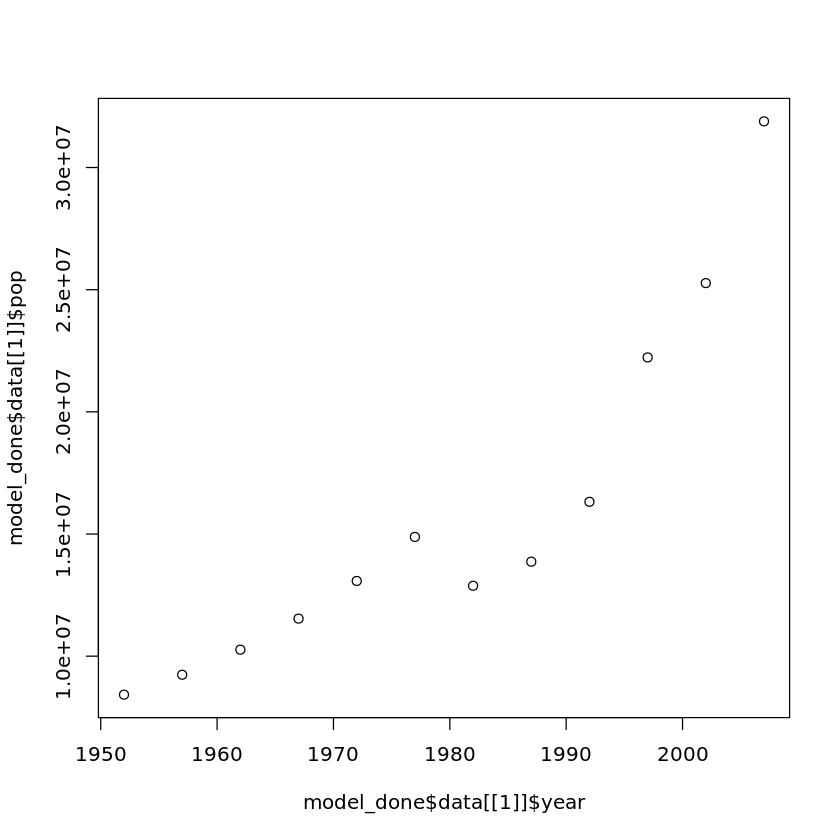

In [53]:
model_done$lm_obj[[1]]

plot(model_done$data[[1]]$year, model_done$data[[1]]$pop)
abline(model_done$lm_obj[[1]])


In [50]:
model_done$lm_obj[[1]][[1]]

(Intercept)           pop     gdpPercap          year 
-7.282995e+02 -3.129846e-07  2.751417e-03  3.882407e-01

###  Rerunning tidyverse in parallel via the furrr package 

In [10]:
# using furrr package

# use all cores available
plan(multicore) 

# this time we do no not need to the evauluation step. 
t1 <- proc.time()
model_done <- 
    country_nested %>%
    mutate(lm_obj = future_map(data, custom_model)) # switched map to future_map!

# switch back to one core
plan(sequential)   
t2 <- proc.time()

print("Elapsed time for furrr example:")
t2 - t1

[1] "Elapsed time for furrr example:"


   user  system elapsed 
  0.518   0.584   4.123 

## Bayesian example using multiple nodes via the future.batchtools package
This example runs multiple bayesian models in parallel by submitting each model to a separate node. This is very useful because each model can already run in parallel for each chain, thus CARC enables you to run all of your bayesian parallelized models at once. the future.batchtools packages will use information in the batchtools.torque.tmpl file in your directory to submit jobs. This file can be modified to modify pbs script  parameters such as length of walltime, number of cores, etc. 

These bayesian models are joint-species distribution models (jSDMs) which fit the distributions of bird species and determines how it relates to their habitat, phylogeny and traits. The code will run four bayesian models that differ in their thinning and then write the models to file. The data and model objects are pre-built and loaded with the hmsc_setup.RData file and are derived from the [bird example](https://www2.helsinki.fi/en/researchgroups/statistical-ecology/hmsc) from their book. 

For the sequential version, I already set up it using future. You can check your future code by running in sequentially by using plan(sequential). Check if nodes are available by running qgrok in a terminal prior to running the parallelized version. 

### Set-up

In [11]:
# bring in data for model
load("hmsc_setup.RData")

# Setting up the model
studyDesign = data.frame(Route = XData$Route)
rL = HmscRandomLevel(sData=xy)
XFormula = ~ hab + poly(clim,degree = 2,raw = TRUE)
TrFormula = ~Migration + LogMass

# parameters for bayesian models. 
nChains = 4
nParallel = 4 
samples = 10


In [12]:
# set up that it will submit pbs scripts for each model
plan(sequential)


m = Hmsc(Y=Y, XData = XData, XFormula=XFormula, 
         phyloTree = phyloTree, TrData = TrData, 
         TrFormula = TrFormula,
         distr="probit", studyDesign=studyDesign, 
         ranLevels=list(Route=rL))
y <- list()
t1 <- proc.time()
# running 4 models, each with a different thinning value
for (thin in c(1,2,3,4)){
  y[[thin]] <- future({
  transient = 50*thin
  m = sampleMcmc(m, thin = thin, samples = samples, transient = transient,
                 nChains = nChains, initPar = "fixed effects",
                 nParallel = nParallel)
                 
  # write model outputs to file               
  filename=file.path(paste0("Big_model_torque_chains_",as.character(nChains),"_samples_",as.character(samples),"_thin_",as.character(thin)))
  save(m,file=filename)
  }, seed = TRUE)
}
# evaluate expression
y <- value(y) 

t2 <- proc.time()
t2 - t1
print("done!")

setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix


   user  system elapsed 
 12.476  12.037 662.881 

[1] "done!"


###  Rerunning bayesian models in parallel using future.batchtools package

In [13]:
# set up that it will submit pbs scripts for each model
# calls upon the batchtools.torque.tmpl file to set the parameters for each job
plan(batchtools_torque)

m = Hmsc(Y=Y, XData = XData, XFormula=XFormula, 
         phyloTree = phyloTree, TrData = TrData, 
         TrFormula = TrFormula,
         distr="probit", studyDesign=studyDesign, 
         ranLevels=list(Route=rL))

y <- list()
t1 <- proc.time()
# running 4 models, each with a different thinning value
for (thin in c(2,3,4,5)){
  y[[thin]] <- future({
  transient = 50*thin
  m = sampleMcmc(m, thin = thin, samples = samples, transient = transient,
                 nChains = nChains, initPar = "fixed effects",
                 nParallel = nParallel)
                 
  # write model outputs to file               
  filename=file.path(paste0("Big_model_torque_chains_",as.character(nChains),"_samples_",as.character(samples),"_thin_",as.character(thin)))
  save(m,file=filename)
  }, seed = TRUE)
}
# evaluate expression
y <- value(y) 

t2 <- proc.time()
t2 - t1



setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix
setting updater$Gamma2=FALSE due to specified phylogeny matrix


   user  system elapsed 
 36.402  68.057 377.659 

In [14]:
overall_t2 <- proc.time()
overall_t2 - overall_t1



    user   system  elapsed 
  56.766   87.902 1130.339 

In [22]:
mins <- (overall_t2[[3]] - overall_t1[[3]])/60
paste0("Total runtime: ", round(mins, 1), " minutes")

[1] "Total runtime: 18.8 minutes"